In [218]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from pytreemap import TreeMap
import pprint as pp
import statistics 
plt.rcParams["figure.figsize"]=5,5
out = 2

In [219]:
def load_match_data(filename):
    all_queries = {
        'S': TreeMap(),
        'POG': TreeMap()
    }
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        isHeader = True

        for row in reader:
            if isHeader:
                isHeader = False
            else:
                l = all_queries[row[2]]
                key = (row[0], row[1])
                size = int(row[3])
                value = { "match" : float(row[9]), "loop" : float(row[10]) }
                if key not in l:
                    l[key] = TreeMap()
                if size not in l[key]:
                    l[key][size] = []
                l[key][size].append(value)

    return all_queries

match_data = load_match_data("bench_2020-12-17-11-26-06.csv")
#match_data = load_match_data("bench_2020-12-02-13-39-24.csv")
#match_data       = load_match_data("bench_2020-12-07-09-55-44.csv")
#match_data = load_match_data("bench_2020-12-16-16-26-42.csv")
repartition_data = load_match_data("bench_2020-12-07-09-55-44.csv")

# { 'S' : { (tool, dataset) : { size : [ { match : T , load : T }, ...], ... } }  , 'POG' : ... }

In [220]:
def load_load_data(filename):
    retval = {}

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        isHeader = True

        for row in reader:
            if isHeader:
                isHeader = False
            else:
                t = (row[0], int(row[1]))
                d = { "memory" : int(row[4]), "time" : float(row[5]) }

                if t not in retval:
                    retval[t] = []
                
                retval[t].append(d)

    return retval

load_data = load_load_data("loadbench_2020-12-02-12-31-50.csv")

# { (dataset, nbOftrees) : [ { "memory" : T, "time" : T }, ... ] }

In [221]:
# Average
def average_geom(l):
    s = 1
    for x in l:
        s *= x
    return s ** (1 / len(l))

def average_arith(l):
    s = 0
    for x in l:
        s += x
    return s / len(l)

def avg_stdev(l):
    return (average_arith(l), statistics.stdev(l))

def avg_stdev2(l):
    lprime = [x * 1024 for x in l]

    average = statistics.mean(l)
    stdev = statistics.stdev(l)

    return (average / 1024, stdev / 1024)


# Reduce a list of dict into one dict
def compact(list_of_dict, reducer):
    retval = TreeMap()

    # list of dict -> dict of list
    for dict in list_of_dict:
        for key in dict:
            if key not in retval:
                retval[key] = []

            retval[key].append(dict[key])

    #print(retval["load"])
    # dict of list -> dict of integer
    for key in dict:
        retval[key].sort()
        retval[key] = retval[key][out:-out] if out != 0 else retval[key]
        retval[key] = reducer(retval[key])

    return retval


reduce_match_data = {}
reduce_match_data_stdev = {}

for pattern in match_data:
    if pattern not in reduce_match_data:
        reduce_match_data[pattern] = {}
        reduce_match_data_stdev[pattern] = {}

    patA = match_data[pattern]
    for dataset in patA:
        if dataset not in reduce_match_data[pattern]:
            reduce_match_data[pattern][dataset] = TreeMap()
            reduce_match_data_stdev[pattern][dataset] = TreeMap()

        datA = patA[dataset]
        for size in datA:
            reduce_match_data[pattern][dataset][size] = compact(datA[size], average_arith)
            reduce_match_data_stdev[pattern][dataset][size] = compact(datA[size], avg_stdev2)

print(reduce_match_data)
#print(reduce_match_data_stdev[pattern][dataset][size])

reduce_load_data = {}
loading_speed = {}


def load_speed(data):
    values = [1000000 / x['time'] for x in data]
    return avg_stdev(values)   

for dataset in load_data:
    reduce_load_data[dataset] = compact(load_data[dataset], average_arith)
    loading_speed[dataset] = load_speed(load_data[dataset])
    
print(reduce_load_data)
print(loading_speed)


{'S': {('rdfjsdataset', 'graphy'): {10000={loop=3.277236960180428e-05, match=4.1929000138264635e-05}, 20000={loop=3.2117521714257154e-05, match=4.2893326031449055e-05}, 40000={loop=3.264919542909965e-05, match=5.040963030541721e-05}, 80000={loop=3.068097818480885e-05, match=4.32503694344474e-05}, 100000={loop=3.0025717397422898e-05, match=4.1900326214406794e-05}, 500000={loop=3.0453043908852585e-05, match=4.193443513434867e-05}, 1000000={loop=3.076865208213744e-05, match=4.21381956776199e-05}}, ('rdfjsdataset', 'tree'): {10000={loop=2.7727912989971426e-05, match=4.8295130629254413e-05}, 20000={loop=2.597228247348381e-05, match=4.864671761574953e-05}, 40000={loop=2.6314130133908724e-05, match=5.2946543523474896e-05}, 80000={loop=2.72725436674512e-05, match=5.720713030060998e-05}, 100000={loop=2.6564934736360693e-05, match=6.081373916695949e-05}, 500000={loop=2.671967406311762e-05, match=6.042595673352479e-05}, 1000000={loop=3.5659086931010945e-05, match=8.356865232243488e-05}}, ('rdfjsd

In [222]:


for key in reduce_load_data:
    s = str(key) + " => " + str(reduce_load_data[key])
    print(s)


('graphy', 1) => {memory=595808.9565217391, time=5.641577076608861}
('tree', 6) => {memory=30994.782608695652, time=12.967600476956443}
('tree', 1) => {memory=30991.565217391304, time=10.809878231869705}
('n3', 3) => {memory=1287200.4347826086, time=6.960175167891278}
('wasm_tree', 6) => {memory=407496.60869565216, time=7.4393268644131085}
('wasm_tree', 1) => {memory=411076.8695652174, time=5.331066180434704}


6
6
3


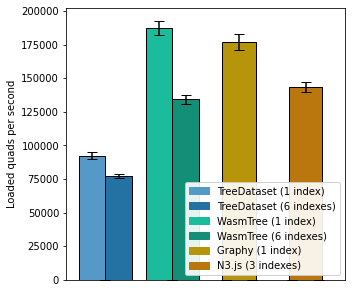

In [230]:
 plt.rcParams["figure.figsize"]=5,5

 import matplotlib.patches as mpatches
 import matplotlib.pyplot as plt

 
 def loading_boxplot(datasets):
    loadings = TreeMap()

    data_left  = { "data" : [], "std" : [], "color": []}
    data_right = { "data" : [], "std" : [], "color": []}
    data       = { "data" : [], "std" : [], "color": []}
    labels     = []
    
    legend_handles = []

    for dataset in datasets:
        d = []
        std = []
        l = []

        extra = ""

        for datum in loading_speed:
            if datum[0] == dataset[0]:
                d.append(loading_speed[datum][0])
                std.append(loading_speed[datum][1])
                l.append(str(datum[1]))

        if len(l) == 2 and l[0] > l[1]:
            d   = [x for x in reversed(d)  ]
            std = [x for x in reversed(std)]
            l   = [x for x in reversed(l)  ]
        
        def make_label(nb):
            s = dataset[1] + " (" + str(nb) + " index"
            if nb != "1":
                print(nb)
                s += "es"
            return s + ")"

        if len(l) == 2:
            legend_handles.append(mpatches.Patch(color=dataset[2], label=make_label(l[0])))
            legend_handles.append(mpatches.Patch(color=dataset[3], label=make_label(l[1])))
        else:
            legend_handles.append(mpatches.Patch(color=dataset[4], label=make_label(l[0])))

        if len(l) == 2:
            data_left["data"].append(d[0])
            data_left["std"].append(std[0])
            data_right["data"].append(d[1])
            data_right["std"].append(std[1])
        else:
            data_left["data"].append(0)
            data_left["std"].append(0)
            data_right["data"].append(0)
            data_right["std"].append(0)

            
        if len(l) == 1:
            data["data"].append(d[0])
            data["std"].append(std[0])
        else:
            data["data"].append(0)
            data["std"].append(0)
        
        data_left ["color"].append(dataset[2])
        data_right["color"].append(dataset[3])
        data      ["color"].append(dataset[4])

        labels.append(dataset[1] + extra)

    color = ['#1f77b4' for x in labels]
    color[-1] = "#ff7f0e"
    plt.bar([x - 0.2 for x in range(len(data_left ["data"]))], data_left ["data"], width=0.4, yerr=data_left ["std"]                   , edgecolor='black', capsize=5, color=data_left ["color"])
    plt.bar([x + 0.2 for x in range(len(data_right["data"]))], data_right["data"], width=0.4, yerr=data_right["std"]                   , edgecolor='black', capsize=5, color=data_right["color"])
    plt.bar([x       for x in range(len(data      ["data"]))], data      ["data"], width=0.5, yerr=data      ["std"]                   , edgecolor='black', capsize=5, color=data      ["color"])
    #                                                                                                   tick_label=labels
    plt.ylabel('Loaded quads per second')

    plt.xticks([])

    plt.legend(handles=legend_handles, loc = 4, framealpha=0.90)

    plt.show()

loading_boxplot([
    ("tree"     , "TreeDataset", "#5499c7", "#2471a3", "yellow"),
    ("wasm_tree", "WasmTree"   , "#1abc9c", "#148f77", "yellow"),
    ("graphy"   , "Graphy"     , "yellow" , "yellow" , "#b7950b"),
    ("n3"       , "N3.js"      , "yellow" , "yellow" , "#b9770e")
])

# TODO : couleurs
# TODO : corriger tree
plt.rcParams["figure.figsize"]=10,5

For S Wasm tree is 9.674 to 1278.741 faster than n3
For POG Wasm tree is 0.987 to 13.671 faster than n3
For S Wasm tree is 3.666 to 4.664 faster than wasm_tree
For POG Wasm tree is 2.732 to 8.220 faster than wasm_tree
===== SUBJECT - DATASET =====
wrap_tree [0.000302783173913865, 0.0003066944785254156, 0.00029964963038978364, 0.00030576076083209207, 0.0003191891742627258, 0.00030626432593587946, 0.00041532145643039897]
tree [7.602304361922584e-05, 7.461900008923335e-05, 7.926067365738362e-05, 8.447967396806117e-05, 8.737867390332018e-05, 8.714563079664241e-05, 0.00011922773925344583]
graphy [7.470136974006891e-05, 7.501084774570621e-05, 8.305882573451687e-05, 7.393134761925625e-05, 7.192604361182969e-05, 7.238747904320125e-05, 7.290684775975734e-05]
wasm_tree [4.6492109156173204e-05, 4.5843413302108e-05, 4.493902210632096e-05, 4.6614478220758225e-05, 4.706041243575189e-05, 5.358547871203526e-05, 4.8767739259030526e-05]
[10000, 20000, 40000, 80000, 100000, 500000, 1000000]


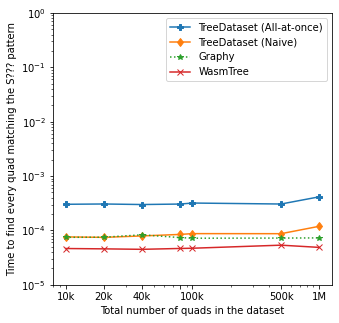

In [249]:
def simple_plot(source, datasets, yminlim, ymaxlim, pat):
    plt.rcParams["figure.figsize"]=5,5

    # # { 'S' : { (tool, dataset) : { size : { match : T , loop : T }, ... } , 'POG' : ... }

    def rename(x):
        #if x < 80000:
        #    return str(x)
        if x == 80000:
            return ""
        if x == 1000000:
            return "1M"
        else:
            return str(x // 1000) + "k"

    for key in datasets:
        x = []
        y = []
        name_x = []

        d = source[(key[0], key[1])]

        for quads in d:
            x.append(quads)
            y.append(d[quads]["match"] + d[quads]["loop"])
            name_x.append(rename(quads))

        l = plt.loglog(x, y, key[3], label=key[2])
        l[0].set_marker(key[4])

        print(key[1], y)

    print(x)
    plt.xticks(x, labels=name_x)
    plt.xlabel("Total number of quads in the dataset")
    plt.ylabel("Time to find every quad matching the " + pat + " pattern")
    #plt.legend()

    axes = plt.gca()
    axes.set_ylim(yminlim, ymaxlim)

    #if q == 'SG':
    #    handles, labels = plt.gca().get_legend_handles_labels()
    #    order = [3, 0, 2, 1, 4]
    #    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    #else:
    plt.legend()

    plt.show()
    pass



subject = [
    ("rdfjsdataset", "wrap_tree", "TreeDataset (All-at-once)", "-", 'P'),
    ("rdfjsdataset", "tree", "TreeDataset (Naive)", "-", "d"),
    ("rdfjsdataset", "graphy", "Graphy", ":", "*"),
    ("rdfjsdataset", "wasm_tree", "WasmTree", "-", 'x')
]

pog = [
    ("rdfjsstore", "n3"       , "n3.js"   , "--", "D"),
    ("rdfjsstore", "wasm_tree", "WasmTree", "-", 'x')
]

def difference(pattern, kind, compared, kind2 = None, compared2 = None):
    if kind2 is None:
        kind2 = kind

    if compared2 is None:
        compared2 = "wasm_tree"

    def get(p, k, c, reducer):
        data    =  reduce_match_data[p][(k, c)]
        data_wt = reduce_match_data[p][(kind2, compared2)]
        return reducer([(data[s]["match"] + data[s]["loop"]) / (data_wt[s]["match"] + data_wt[s]["loop"]) for s in data])

    cmin = get(pattern, kind, compared   , min)
    cmax = get(pattern, kind, compared   , max)
    print("For " + pattern + " Wasm tree is " + "{:0.3f}".format(cmin) + " to " + "{:0.3f}".format(cmax) + " faster than " + compared)
    return cmin, cmax


#difference("S", "rdfjsdataset", "graphy")
#difference("POG", "rdfjsdataset", "graphy")
difference("S", "rdfjsstore", "n3")
difference("POG", "rdfjsstore", "n3")
#difference("S", "rdfjsstore", "wasm_tree", "rdfjsdataset")
#
difference("S", "rdfjsstore", "wasm_tree", "rdfjsdataset")
difference("POG", "rdfjsstore", "wasm_tree", "rdfjsdataset")

print("===== SUBJECT - DATASET =====")
simple_plot(reduce_match_data['S']  , subject, 10**-5, 1, "S???")


===== POG - DATASET =====
wrap_tree [0.012071039500322355, 0.021435975260263227, 0.049069414108424726, 0.0864658486303752, 0.09319997963042038, 0.4302525105438316, 0.8285294670654947]
tree [0.005236766456666849, 0.011343237369321284, 0.019114757456857222, 0.03594467045686653, 0.04368398786975962, 0.28076113154334215, 0.5670468567607763]
graphy [0.0064133624128754375, 0.006308831891611867, 0.008179471456162307, 0.017495227261001, 0.02474873602204025, 0.21121675799981404, 0.21254658960883066]
wasm_tree [0.0013870023698748454, 0.001515598304488737, 0.0009972181305208283, 0.001077060696102031, 0.0012833067611183807, 0.005886572152376177, 0.010614451804157831]
[10000, 20000, 40000, 80000, 100000, 500000, 1000000]


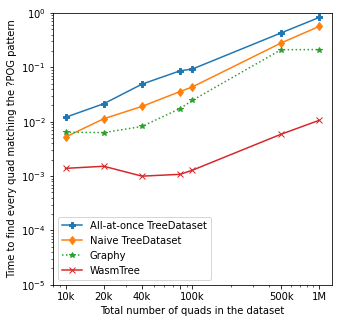

In [248]:

print("===== POG - DATASET =====")
simple_plot(reduce_match_data['POG'] , subject, 10**-5, 1, "?POG")


===== SUBJECT - STORE =====
n3 [0.001852464478098504, 0.003386590390871076, 0.00837209578247174, 0.014647786347883876, 0.017857936261343244, 0.10607441078219565, 0.22861646778225575]
wasm_tree [0.00019148947837074166, 0.00018915493510987454, 0.00019087336945306996, 0.00019340076091010932, 0.00019848902219825462, 0.00024993791329957864, 0.00017878252166606811]
[10000, 20000, 40000, 80000, 100000, 500000, 1000000]


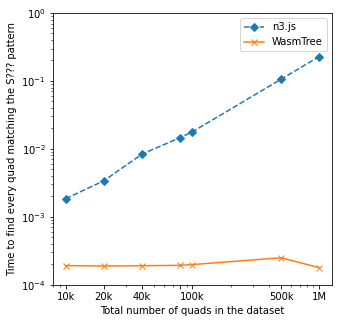

In [236]:

print("===== SUBJECT - STORE =====")
simple_plot(reduce_match_data['S']  , pog, 10**-4, 1, "S???")

===== POG - STORE =====
n3 [0.004278931434711685, 0.018635916912847238, 0.017420650152570525, 0.07697698378287582, 0.0677319057609724, 0.10756289191329446, 0.5428980191520456]
wasm_tree [0.004333352347673929, 0.004140699281924122, 0.007750752760745262, 0.008853950544017488, 0.009255417673848569, 0.023940350043303936, 0.03971107304339175]
[10000, 20000, 40000, 80000, 100000, 500000, 1000000]


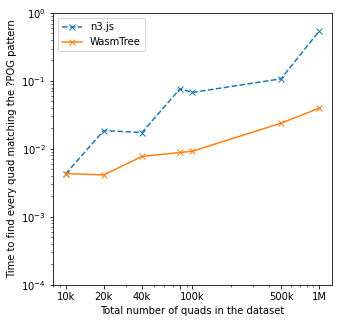

In [227]:

print("===== POG - STORE =====")
simple_plot(reduce_match_data['POG'], pog    , 10**-4, 1     , "?POG")


In [228]:
def s(d, r="S"):
    x =reduce_match_data[r][d][1000000]
    return x['loop'] + x['match']

p_wtdfs = s(('rdfjsdataset', 'wasm_tree_FS'), "POG")
p_wt = s(('rdfjsdataset', 'wasm_tree'), "POG")
p_graphy = s(('rdfjsdataset', 'graphy'), "POG")

a_wtdfs = s(('rdfjsdataset', 'wasm_tree_FS'))
a_graphy = s(('rdfjsdataset', 'graphy'))
a_wtd = s(('rdfjsdataset', 'wasm_tree'))
#a_wts = s(('rdfjsstore'  , 'wasm_tree'))
#a_n3 = s(('rdfjsstore'  , 'n3'))
print(a_wtd)
print(a_wts)
print(a_n3)

print("ws / wd = ", a_wts / a_wtd)
print("n3 / ws = ", a_n3 / a_wts)

for x in [a_wtd, a_wtdfs]:
    print(a_graphy / x)

for x in [p_wt, p_wtdfs]:
    print(p_graphy / x)


KeyError: ('rdfjsdataset', 'wasm_tree_FS')

{'S': {('rdfjsdataset', 'graphy'): {1000000={loop=(3.009558116673361e-08, 1.144059066153361e-09), match=(4.224530022156614e-08, 1.330468748584403e-09)}}, ('rdfjsdataset', 'tree'): {1000000={loop=(3.553149394974753e-08, 6.454794991838051e-09), match=(8.278881830392493e-08, 1.1903714285903723e-08)}}, ('rdfjsdataset', 'wasm_tree'): {1000000={loop=(1.3371765135161696e-08, 2.5351948829984556e-10), match=(3.428625456081136e-08, 1.3452636111025454e-09)}}, ('rdfjsdataset', 'wasm_tree_FI'): {1000000={loop=(1.948669421381055e-08, 3.9264762322411064e-10), match=(6.70291139499568e-08, 1.1040010039946345e-09)}}, ('rdfjsdataset', 'wasm_tree_FS'): {1000000={loop=(1.7798767032672914e-08, 4.873777881293906e-10), match=(3.286682107273009e-08, 6.252428642315222e-10)}}, ('rdfjsdataset', 'wasm_tree_II'): {1000000={loop=(1.3925109897172661e-08, 6.677454716397455e-10), match=(6.728973357894575e-08, 8.225818546761976e-10)}}, ('rdfjsdataset', 'wrap_tree'): {1000000={loop=(3.4530041511970923e-07, 7.902582329312

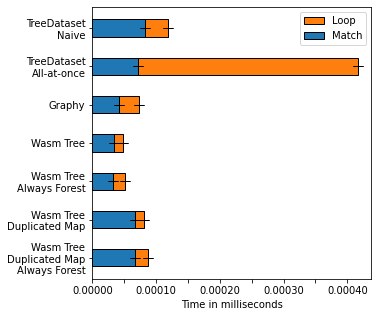

{'tree': {'match': 0.0003960988052368748, 'loop': 0.00017432367700206443}, 'wrap_tree': {'match': 0.00039550282867423903, 'loop': 0.00043357632653822975}, 'graphy': {'match': 0.000135062112792923, 'loop': 7.313574725333183e-05}, 'wasm_tree': {'match': 6.931704467490363e-06, 'loop': 3.825855773925469e-06}, 'wasm_tree_FS': {'match': 5.307701098610096e-05, 'loop': 1.075572204575792e-05}, 'wasm_tree_II': {'match': 0.0001613314188844015, 'loop': 3.3801240234652143e-06}, 'wasm_tree_FI': {'match': 0.0002075578203127293, 'loop': 9.887578918437611e-06}}
['tree', 'wrap_tree', 'graphy', 'wasm_tree', 'wasm_tree_FS', 'wasm_tree_II', 'wasm_tree_FI']
[0.3960988052368748, 0.395502828674239, 0.13506211279292302, 0.006931704467490363, 0.05307701098610096, 0.1613314188844015, 0.2075578203127293]
[0.17432367700206441, 0.43357632653822975, 0.07313574725333183, 0.003825855773925469, 0.01075572204575792, 0.003380124023465214, 0.009887578918437612]


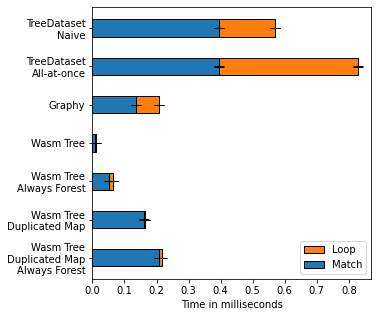

{1000000={loop=(1.3371765135161696e-08, 2.5351948829984556e-10), match=(3.428625456081136e-08, 1.3452636111025454e-09)}}
{1000000={loop=(3.009558116673361e-08, 1.144059066153361e-09), match=(4.224530022156614e-08, 1.330468748584403e-09)}}
{1000000={loop=(3.825855773925469e-06, 1.5156020523043925e-07), match=(6.931704467490363e-06, 1.2270686303349012e-07)}}
{1000000={loop=(7.313574725333183e-05, 2.1493519428863116e-06), match=(0.000135062112792923, 1.8228419184885501e-06)}}


In [217]:
from matplotlib.ticker import FuncFormatter

#def MyFormatter(x,lim):
#    if x == 0:
#        return 0
#    return "$" + str(x / 1000) + " . 10^-3$"
    #return '{0:.2f}e{1:.2f}'.format(np.sign(x)*10**(-np.floor(np.log10(abs(x)))+np.log10(abs(x))),np.floor(np.log10(abs(x))))

import matplotlib.ticker as plticker

def repartition(data, requiredS, hide_2th=None):
    plt.rcParams["figure.figsize"]=5,5
    matches = []
    stdmatches = []
    foreaches = []
    stdforeaches = []
    names = []
    names_ = []

    a = {}

    xs = []

    for required in requiredS:
        d = data[(required[0], required[1])][1000000]

        matches     .append(d["match"][0] * 1000)
        stdmatches  .append(d["match"][1] * 1000)
        foreaches   .append(d["loop" ][0] * 1000)
        stdforeaches.append(d["loop" ][1] * 1000)
                
        names.append(required[1])
        names_.append(required[2])

        a[required[1]] = { 'match': d["match"][0], "loop": d["loop"][0] }
        xs.append((d["match"][0] + d["loop"][0] + d["loop"][1]) * 1000)
    
    print(a)

    ind = [x for x in range(len(requiredS))]
    
    fig, ax = plt.subplots()
    pmatch = plt.barh(ind, matches  , 0.45,               yerr=stdmatches  , edgecolor='black', capsize=5, tick_label=names)
    pforea = plt.barh(ind, foreaches, 0.45, left=matches, yerr=stdforeaches, edgecolor='black', capsize=5)
    print(names)
    print(matches)
    print(foreaches)

    plt.legend((pforea[0], pmatch[0]), ("Loop", "Match"))
    plt.yticks(ind, names_)
    plt.xlabel("Time in milliseconds")
    mheight = max([matches[i] + foreaches[i] + stdforeaches[i] for i in range(len(matches))])
    plt.gca().invert_yaxis()
    
    #majorFormatter = FuncFormatter(MyFormatter)
    #ax.yaxis.set_major_formatter(majorFormatter)
    #plt.ticklabel_format(axis="x", style="plain", scilimits=(0,0))
    if hide_2th:
        i = 0
        for label in ax.get_xticklabels():
            if i % 2 == 1:
                label.set_visible(False)
            i += 1

    plt.show()

subject = [
    ("rdfjsdataset", "tree", "TreeDataset\nNaive", "-"),
    ("rdfjsdataset", "wrap_tree", "TreeDataset\nAll-at-once", "-"),
    ("rdfjsdataset", "graphy", "Graphy", ":"),
    ("rdfjsdataset", "wasm_tree", "Wasm Tree", "-"),
    ("rdfjsdataset", "wasm_tree_FS", "Wasm Tree\nAlways Forest"),
    ("rdfjsdataset", "wasm_tree_II", "Wasm Tree\nDuplicated Map"),
    ("rdfjsdataset", "wasm_tree_FI", "Wasm Tree\nDuplicated Map\nAlways Forest")
]

print(reduce_match_data_stdev)

repartition(reduce_match_data_stdev['S'], subject, True)
repartition(reduce_match_data_stdev['POG'], subject)

print(reduce_match_data_stdev['S'][('rdfjsdataset', 'wasm_tree')])
print(reduce_match_data_stdev['S'][('rdfjsdataset', 'graphy')])

print(reduce_match_data_stdev['POG'][('rdfjsdataset', 'wasm_tree')])
print(reduce_match_data_stdev['POG'][('rdfjsdataset', 'graphy')])


In [31]:
print(reduce_match_data_stdev)

{'S': {('rdfjsdataset', 'graphy'): {1000000={loop=(3.009558116673361e-08, 1.144059066153361e-09), match=(4.224530022156614e-08, 1.330468748584403e-09)}}, ('rdfjsdataset', 'tree'): {1000000={loop=(3.553149394974753e-08, 6.454794991838051e-09), match=(8.278881830392493e-08, 1.1903714285903723e-08)}}, ('rdfjsdataset', 'wasm_tree'): {1000000={loop=(1.3371765135161696e-08, 2.5351948829984556e-10), match=(3.428625456081136e-08, 1.3452636111025454e-09)}}, ('rdfjsdataset', 'wasm_tree_FI'): {1000000={loop=(1.948669421381055e-08, 3.9264762322411064e-10), match=(6.70291139499568e-08, 1.1040010039946345e-09)}}, ('rdfjsdataset', 'wasm_tree_FS'): {1000000={loop=(1.7798767032672914e-08, 4.873777881293906e-10), match=(3.286682107273009e-08, 6.252428642315222e-10)}}, ('rdfjsdataset', 'wasm_tree_II'): {1000000={loop=(1.3925109897172661e-08, 6.677454716397455e-10), match=(6.728973357894575e-08, 8.225818546761976e-10)}}, ('rdfjsdataset', 'wrap_tree'): {1000000={loop=(3.4530041511970923e-07, 7.902582329312